In [ ]:
!git clone https://github.com/ria-com/nomeroff-net.git

fatal: destination path 'nomeroff-net' already exists and is not an empty directory.


In [ ]:
%cd nomeroff-net

/content/nomeroff-net


In [ ]:
!pip3 install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lilohuang/PyTurboJPEG.git to /tmp/pip-install-wilwxcwn/pyturbojpeg_330ab544ffed4dc8b7049de4bf8d6484
  Running command git clone -q https://github.com/lilohuang/PyTurboJPEG.git /tmp/pip-install-wilwxcwn/pyturbojpeg_330ab544ffed4dc8b7049de4bf8d6484
  Cloning https://github.com/ria-com/modelhub-client.git to /tmp/pip-install-wilwxcwn/modelhub-client_0dc9daaa4fca432cb0f1df83577c567c
  Running command git clone -q https://github.com/ria-com/modelhub-client.git /tmp/pip-install-wilwxcwn/modelhub-client_0dc9daaa4fca432cb0f1df83577c567c
     |████████████████████████████████| 101 kB 3.8 MB/s 
     |████████████████████████████████| 181 kB 26.2 MB/s 
     |████████████████████████████████| 708 kB 44.3 MB/s 
     |████████████████████████████████| 5.8 MB 48.8 MB/s 
     |████████████████████████████████| 170 kB 63.0 MB/s 
     |████████████████████████████████| 63 kB 1.

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from torch import no_grad
from typing import Any, Dict, Optional, Union
from nomeroff_net.image_loaders import BaseImageLoader
from nomeroff_net.pipelines.base import Pipeline
from nomeroff_net.tools import unzip
from nomeroff_net.pipes.number_plate_localizators.yolo_v5_detector import Detector

git clone https://github.com/clovaai/CRAFT-pytorch.git


0it [00:02, ?it/s]


git clone https://github.com/ultralytics/yolov5.git


100%|██████████| 9150.0/9150.0 [00:04<00:00, 2127.02it/s]


In [ ]:
from nomeroff_net.tools.mcm import (modelhub, get_mode_torch)
from nomeroff_net.tools.image_processing import (distance,
                                                 get_cv_zone_rgb,
                                                 crop_image,
                                                 minimum_bounding_rectangle,
                                                 reshape_points,
                                                 normalize_img)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_to_data = '/content/drive/MyDrive/Colab Notebooks/Car_plates/data'

In [ ]:
detector = Detector()
detector.load()

Downloaded model path: /content/nomeroff-net/nomeroff_net/tools/../../data/./models/Detector/yolov5/yolov5s-2022-07-25.pt


yolov5s-2022-07-25.pt: 14.4MB [00:02, 6.33MB/s]                            
YOLOv5 🚀 v6.2-185-ge4398cf Python-3.7.14 torch-1.12.1+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
def direction(source):
    cap = cv2.VideoCapture(f'{path_to_data}/{source}.mp4')
    
    frame_width = int( cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int( cap.get( cv2.CAP_PROP_FRAME_HEIGHT))

    ret, frame1 = cap.read()
    ret, frame2 = cap.read()

    list_x=[]
    s=0
    s_count = 0

    while cap.isOpened() and frame2 is not None:
        diff = cv2.absdiff(frame1, frame2)
        gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        _, thresh = cv2.threshold(blur, 25, 255, cv2.THRESH_BINARY)
        dilated = cv2.dilate(thresh, None, iterations=3)
        contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        areas = [cv2.contourArea(c) for c in contours]        
        if len(areas) != 0:
            max_index = np.argmax(areas)
            cnt=contours[max_index]  
        
            (x, y, w, h) = cv2.boundingRect(cnt)
            list_x.append(x)

        model_outputs = detector.predict(frame1)
        try:
            len(model_outputs[0][0])
            xp1, yp1, xp2, yp2, p, cl = model_outputs[0][0]
            if abs(xp2-xp1)*abs(yp2-yp1)>s and abs(xp2-xp1)/abs(yp2-yp1)>3.1:
                img_res = frame1
                s = abs(xp2-xp1)*abs(yp2-yp1)
        except:
            pass
            
        frame1 = frame2
        ret, frame2 = cap.read()
        if cv2.waitKey(40) == 27:
            break

    model_outputs = detector.predict(img_res)
    model_outputs_int = [int(i) for i in model_outputs[0][0]]
    x1_res, y1_res, x2_res, y2_res, p, cl = model_outputs_int
    img_res_bbox = img_res.copy()
    cv2.rectangle(img_res_bbox, 
                  (x1_res, y1_res), 
                  (x2_res, y2_res), 
                  (0, 255, 255), 
                  thickness = 1, 
                  lineType=cv2.LINE_AA)
    cv2_imshow(img_res_bbox)

    list_dir = []
    list_dir = [list_x[i+1] - list_x[i] for i in range(0, len(list_x)-1)]
    list_dir = list(filter(lambda x: x != 0 and abs(x) < 25, list_dir))

    if sum(list_dir) > 0:
        print(f'{source}: машина выехала')
    else:
        print(f'{source}: машина заехала')        

    image_part, (x, w, y, h) = crop_image(img_res, model_outputs_int[0:4])

    img_norm = cv2.resize(image_part, (520, 155))
    gray_norm = cv2.cvtColor(img_norm, cv2.COLOR_BGR2GRAY)
    ret3, th3 = cv2.threshold(gray_norm,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    contours2, _ = cv2.findContours(th3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours2:
        rect = cv2.minAreaRect(cnt)  # пытаемся вписать прямоугольник
        box = cv2.boxPoints(rect)  # поиск четырех вершин прямоугольника
        box = np.int0(box)  # округление координат
        if abs(box[2][0] - box[0][0])*abs(box[1][1] - box[3][1]) > s_count:
            s_count = abs(box[2][0] - box[0][0])*abs(box[1][1] - box[3][1])
            box_res = box
            rect_max = rect
    
    
    cv2.drawContours(img_norm, [box_res], -1, (255, 0, 0), 2)
 
    cv2_imshow(img_norm)

    #dilated2 = cv2.dilate(th3, None, iterations=1)
    cv2_imshow(crop_minAreaRect(th3, rect_max))

    cv2.destroyAllWindows()
    cap.release()

In [ ]:
def crop_minAreaRect(img, rect):
    #  начал
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    W = rect[1][0]
    H = rect[1][1]

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    rotated = False

    #так
    angle = rect[2]
    if angle > 45:
        angle -= 90
        rotated = True 

    center = (int((x1+x2)/2), int((y1+y2)/2))
    size = (int(x2-x1),int(y2-y1))
    #cv2.circle(img, center, 10, (0,255,0), -1) #again this was mostly for debugging purposes

    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

    cropped = cv2.getRectSubPix(img, size, center)    
    cropped = cv2.warpAffine(cropped, M, size)

    croppedW = W if not rotated else H 
    croppedH = H if not rotated else W

    croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW), int(croppedH)), (size[0]/2, size[1]/2))
    #rows,cols = img.shape[0], img.shape[1]
    #M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    #img_rot = cv2.warpAffine(img,M,(cols,rows))
    print()
    return croppedRotated

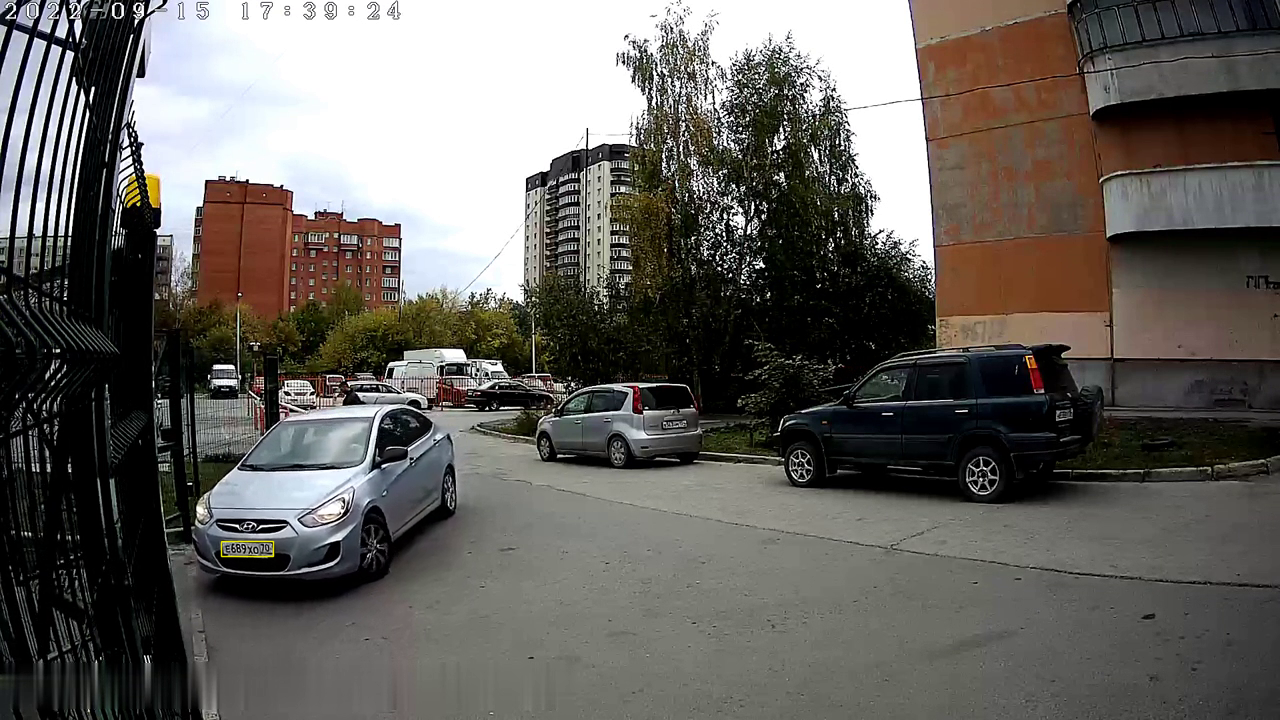

video_1: машина заехала


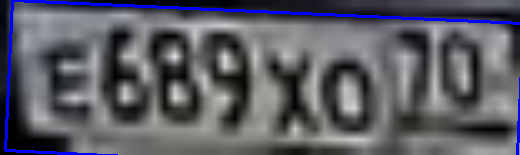

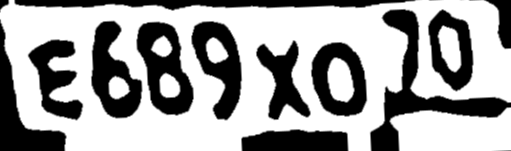

In [ ]:
direction('video_1')

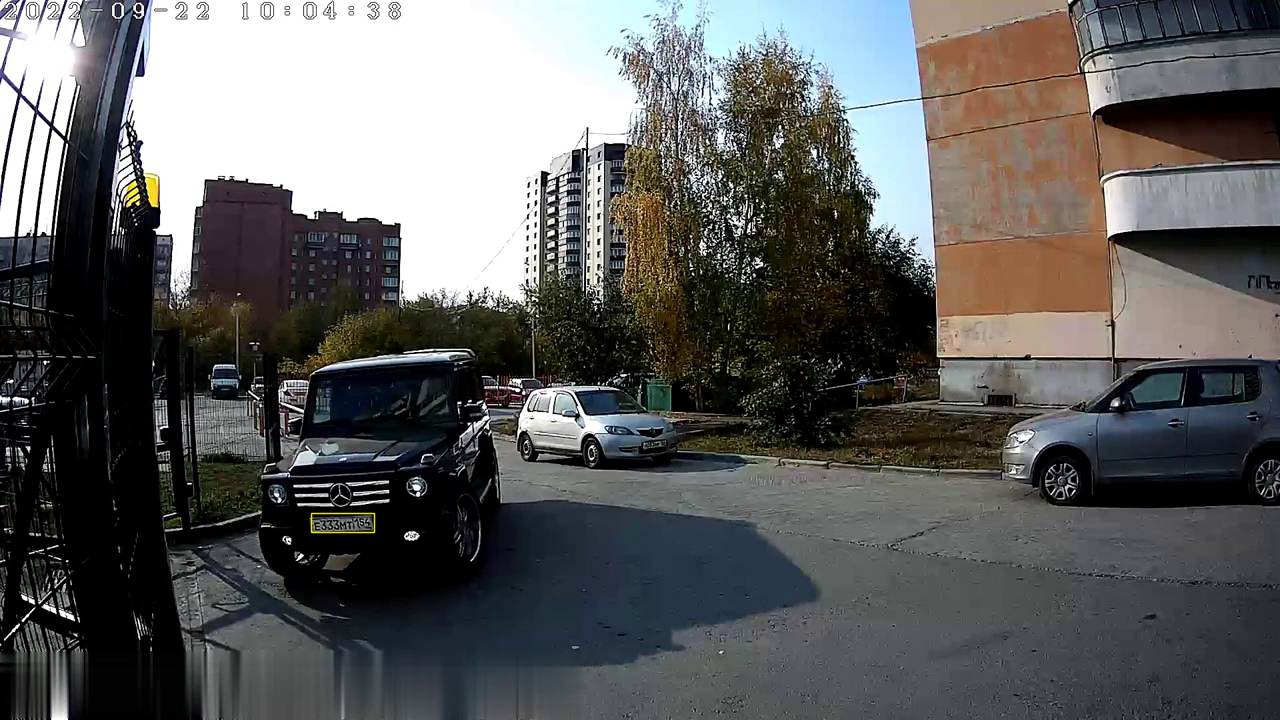

video_2: машина заехала


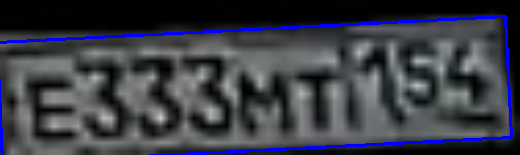

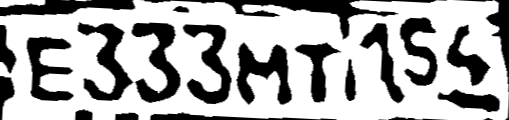

In [ ]:
direction('video_2')

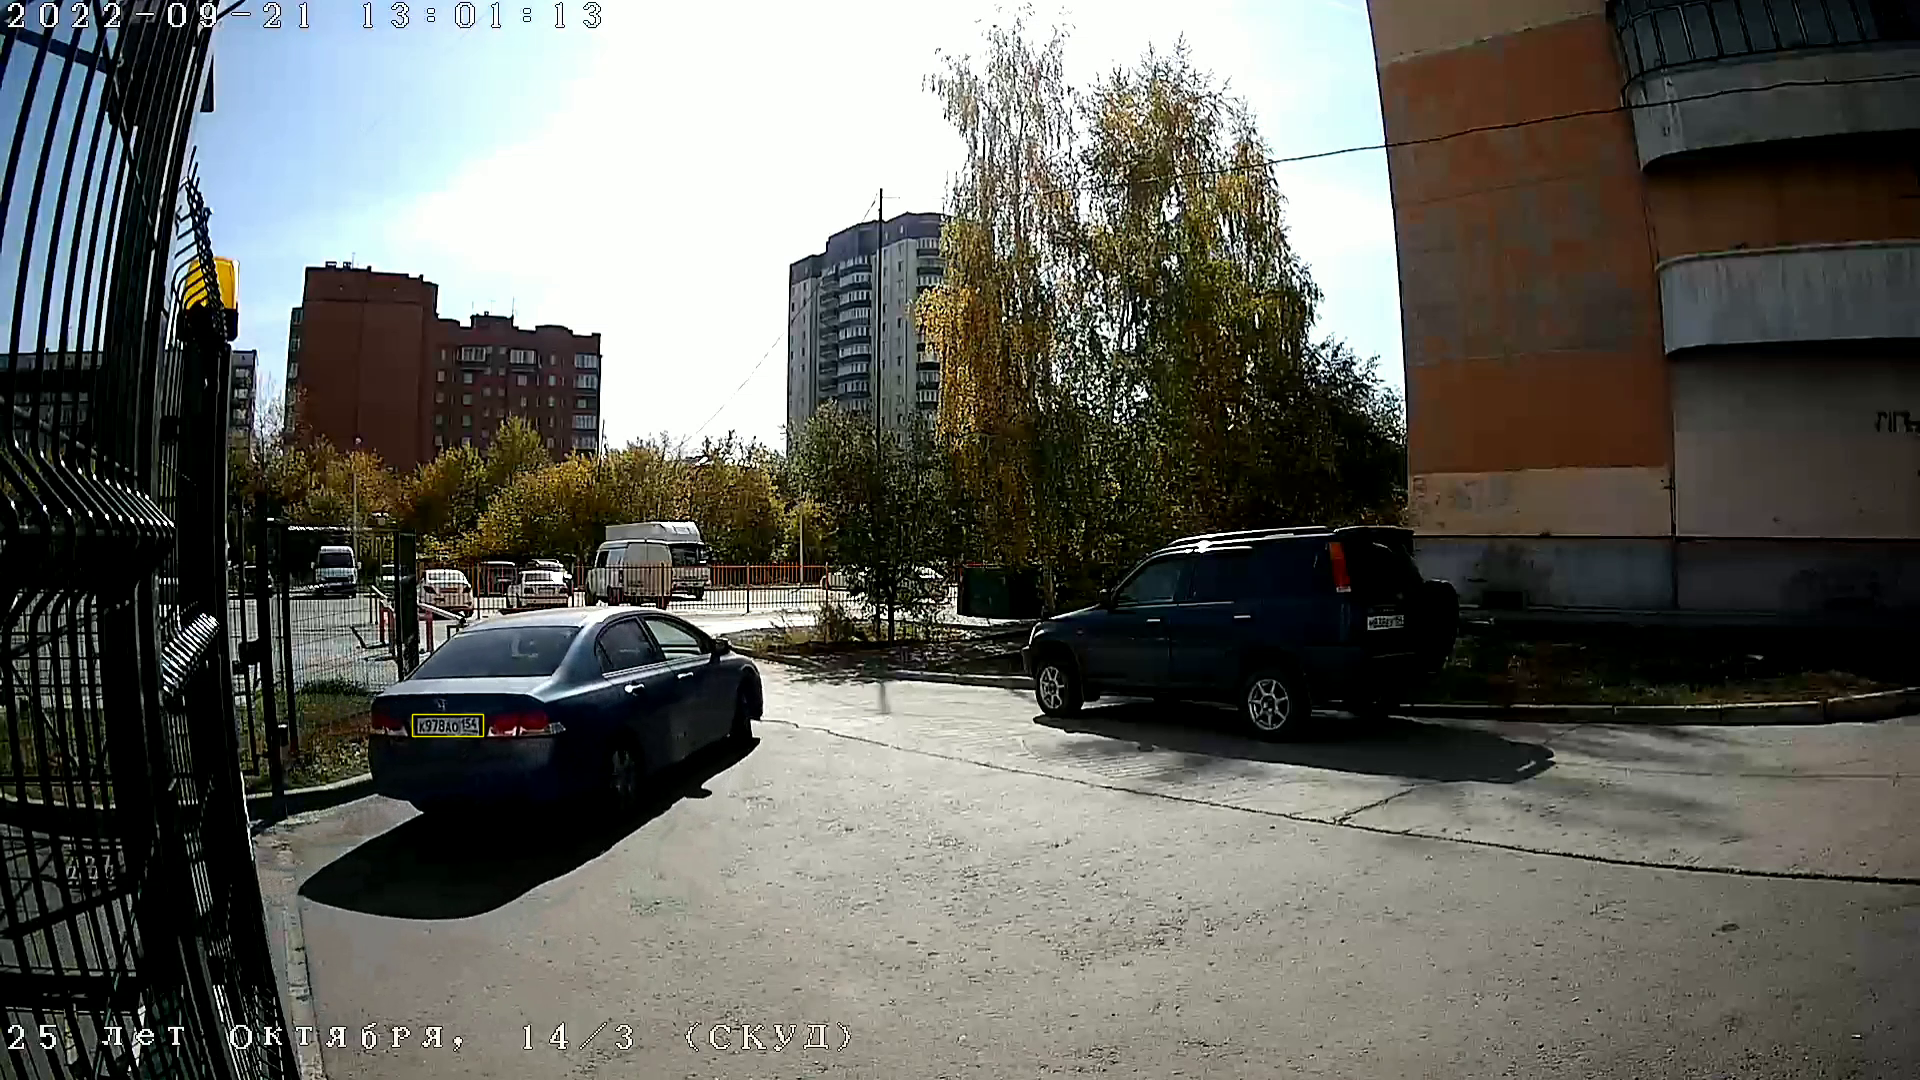

video_3: машина выехала


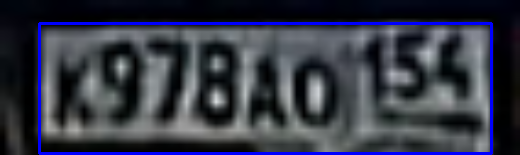

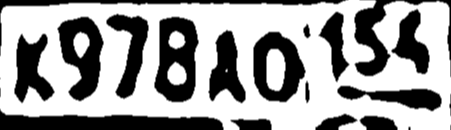

In [ ]:
direction('video_3')